In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Fetching data

In [19]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

# Utils, plotting

In [20]:
def read_dataset(path):
    df = pd.read_csv(path)
    return df

def plot(title, x1, y1, label1 = None, title1 = None, 
         x2 = None, 
         y2 = None, 
         label2 = None, 
         title2 = None,
         mode1 = 'yo',
         mode2 = 'g^'):
    
    plt.plot(x1, y1, mode1, label = label1 if label1 is not None else '')
    if x2 is not None and y2 is not None:
        plt.plot(x2, y2, mode2, label = label2 if label2 is not None else '')
        
    plt.title(title)
    plt.xlabel(title1 if title1 is not None else '')
    plt.ylabel(title2 if title2 is not None else '')
    
    plt.legend()
    plt.show()
    
def plot3d(title, x1, y1, z1, x2 = None, y2 = None, z2 = None, label1 = None, label2 = None,
           xtitle=None, ytitle=None, ztitle=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x1, y1, z1, c='red', label=label1 if label1 is not None else '')
    if x2 is not None and y2 is not None and z2 is not None:
        ax.scatter(x2, y2, z2, c='blue', marker='^',label=label2 if label2 is not None else '')
    ax.set_xlabel(xtitle if xtitle is not None else '')
    ax.set_ylabel(ytitle if ytitle is not None else '')
    ax.set_zlabel(ztitle if ztitle is not None else '')
    ax.set_title(title)
    ax.legend()
    plt.show()
    

# Data

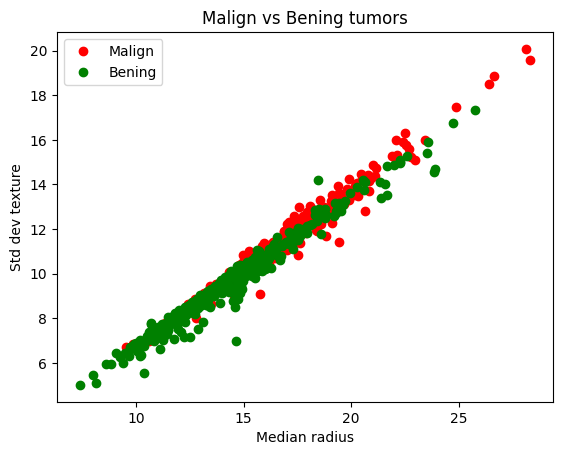

In [25]:
median_radius = [(x + y + z) / 3 for (x,y,z) in zip(X['texture1'], X['texture2'], X['texture3'])]
std_texture = [np.std([x, y, z]) for (x, y, z) in zip(X['texture1'], X['texture2'], X['texture3'])]

median_radius = np.array(median_radius)
std_texture = np.array(std_texture)
y = np.array(y).ravel()

plot(title='Malign vs Bening tumors', 
     x1=median_radius[y == 'M'], 
     y1=std_texture[y == 'M'], 
     label1='Malign',
     x2=median_radius[y == 'B'], 
     y2=std_texture[y == 'B'], 
     label2='Bening', 
     title1='Median radius', 
     title2='Std dev texture', 
     mode1='ro', mode2='go')



# Train test split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(list(zip(median_radius, std_texture)), y, test_size=0.2, random_state=21)